## Tic-Tac-Toe Agent
​
An RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook

        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries

In [19]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env import TicTacToe
import collections
import numpy as np
from numpy import nan
import random
import pickle
import time
from matplotlib import pyplot as plt
from tqdm import tqdm

In [20]:
# Initialize the Q-Table and state-tracker
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [21]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','X')

In [22]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.
def valid_actions(env, state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [23]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(env, state):
    state1 = Q_state(state)
    #capture the valid agent actions for state 
    valid_act = valid_actions(env, state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [24]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
max_epsilon = 1.0
min_epsilon = 0.001
def epsilon_greedy(state, time):
    epsilon_val = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    z = np.random.random()
    # Convert state array to state strng
    stae_str = Q_state(state)
    if z > epsilon_val: #Exploitation: this gets the action corresponding to max q-value of current state
        action = max(Q_dict[stae_str], key=Q_dict[stae_str].get)
    else:
        # get available actions for agent and pick random action from it
        agent_actions = list(env.action_space(state)[0])
        random_action_index = np.random.choice(len(agent_actions))
        action = agent_actions[random_action_index]
    return action

#### Tracking the state-action pairs for checking convergence

In [25]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)


In [26]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [('X-2-X-X-X-X-X-X-5', (7, 9)), ('X-3-X-X-X-X-8-X-X', (4, 5)), ('X-X-X-X-1-2-X-X-X', (8, 7)),
                       ('1-X-X-4-X-6-7-X-X', (4, 5)), ('4-6-X-5-X-3-X-X-X', (4, 7)), ('X-6-4-3-1-X-X-X-X', (0, 5)),
                      ('X-X-4-3-X-X-X-X-X', (5, 9)), ('X-X-X-X-7-X-X-X-8', (0, 5)), ('8-X-X-X-4-5-7-X-X', (8, 3))]
  
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        # Initialize q-values and state
        States_track[state][action] = [] # This is an array which will have appended values of that state-action pair for every 2000th episode 

In [27]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [28]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

#### Define hyperparameters 

In [29]:
#Defining parameters for the experiment

EPISODES = 5000000
LR = 0.001                   #learning rate
# LR = 0.005
GAMMA = 0.91

threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 30000    #every these many episodes, the Q-dict will be updated
total_rewards_final_500_episodes = []

### Q-update loop

In [30]:
start_time = time.time()

for episode in tqdm(range(EPISODES)):
    ##### Start writing your code from the next line
    # create environment
    env = TicTacToe()
    
    # check whether state is reached to terminal state by agent Win, Loose or Tie
    reached_terminal_state = False
    
    reward = None
    total_reward = 0
    
    # Initialize initial stat and current state
    curr_state = env.state  
    # add current initial state to q_table
    add_to_dict(env, curr_state)
    
    # Every episode we check reward until we reach terminal state
    while not reached_terminal_state:
        #curr_action is a_tue and is a(t-1)      
        curr_action = epsilon_greedy(curr_state, episode)
        
        # Convert state array to state strng
        curr_state_str = Q_state(curr_state)
        
        next_state, reward, reached_terminal_state = env.step(curr_state, curr_action)
        
        # add next_state to Q_dict dictionary
        add_to_dict(env, next_state)
        
        # Convert state array to state strng
        next_state_str = Q_state(next_state)
        
        if not reached_terminal_state:
            # Update Rule
            max_next_action = max(Q_dict[next_state_str], key=Q_dict[next_state_str].get)

            #update current value
            Q_dict[curr_state_str][curr_action] += LR * ((reward + GAMMA * Q_dict[next_state_str][max_next_action]) - Q_dict[curr_state_str][curr_action])
        else:
            Q_dict[curr_state_str][curr_action] += LR * (reward - Q_dict[curr_state_str][curr_action])
            
        curr_state = next_state
        
        total_reward += reward
        # capturing last 200 episodes rewards after reached to terminal state
        if(reached_terminal_state and episode >= (EPISODES - 500)):
            total_rewards_final_500_episodes.append(total_reward)
            
    
    #TRACKING Q-VALUES
    if (episode == threshold -  1): # at 1999th episode initialize tracking
        initialise_tracking_states()
        
    # Save states periodically in pickle file
    if ((episode + 1) % threshold == 0):
        save_tracking_states()
    
elapsed_time = time.time() - start_time
print('Total time Elapsed for episodes: {0} training: {1}'.format(EPISODES, elapsed_time))
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000000/5000000 [1:32:04<00:00, 904.98it/s]


Total time Elapsed for episodes: 5000000 training: 5525.002005577087


In [31]:
# Print last 500 episodes reward values
total_rewards_final_500_episodes

[7,
 8,
 8,
 8,
 8,
 -13,
 8,
 -4,
 -12,
 -4,
 8,
 8,
 -4,
 -4,
 -11,
 8,
 -12,
 8,
 6,
 8,
 -4,
 8,
 6,
 7,
 8,
 8,
 8,
 6,
 -12,
 -4,
 8,
 8,
 7,
 8,
 8,
 8,
 -4,
 7,
 7,
 -13,
 -4,
 -4,
 8,
 -4,
 8,
 8,
 -4,
 -13,
 8,
 -4,
 -4,
 -4,
 7,
 8,
 8,
 -13,
 8,
 8,
 7,
 8,
 7,
 -4,
 6,
 8,
 8,
 8,
 8,
 8,
 -12,
 8,
 -4,
 -4,
 8,
 -12,
 7,
 8,
 8,
 8,
 8,
 -4,
 -12,
 8,
 -4,
 8,
 8,
 -4,
 6,
 -4,
 -4,
 7,
 6,
 -4,
 -4,
 8,
 8,
 -4,
 8,
 6,
 8,
 8,
 -4,
 -4,
 8,
 -4,
 8,
 8,
 -4,
 -12,
 8,
 -4,
 8,
 8,
 -12,
 8,
 6,
 8,
 -4,
 -4,
 8,
 8,
 8,
 8,
 -4,
 8,
 7,
 -12,
 -13,
 8,
 7,
 8,
 -4,
 -4,
 8,
 8,
 7,
 8,
 -4,
 -4,
 8,
 -4,
 8,
 -4,
 -13,
 -12,
 8,
 8,
 8,
 8,
 -4,
 6,
 8,
 8,
 8,
 8,
 -12,
 8,
 -4,
 -11,
 8,
 8,
 -4,
 -4,
 -12,
 8,
 8,
 7,
 -4,
 8,
 8,
 8,
 7,
 -4,
 -12,
 -13,
 -12,
 8,
 8,
 8,
 7,
 8,
 7,
 8,
 7,
 -4,
 8,
 -4,
 -4,
 -4,
 -11,
 6,
 -4,
 8,
 8,
 -4,
 -4,
 8,
 8,
 7,
 -4,
 8,
 -4,
 8,
 6,
 8,
 -4,
 8,
 -13,
 8,
 7,
 7,
 7,
 8,
 7,
 -4,
 -4,
 8,
 -13,
 8,
 8,
 8,
 -13,
 6,
 

####  Plot using captured agent rewards for lost 500 episodes during training

Agent Win details for last 500 episodes:  {'Win': 309, 'Loss': 70, 'Tie': 121}


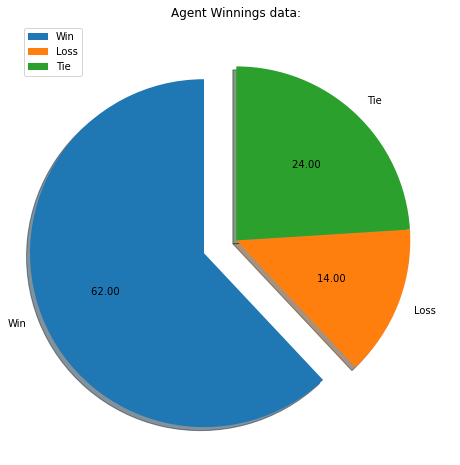

In [32]:
# plot pie chat for last 500 episodes agents's win, tie and loss rates
agent_win_rates = {'Win':0, 'Loss': 0, 'Tie': 0}

for agent_reward in total_rewards_final_500_episodes:
    if(agent_reward > 0):
        agent_win_rates['Win'] += 1
    elif(agent_reward > -10):
        agent_win_rates['Tie'] += 1
    else:
        agent_win_rates['Loss'] += 1
        
print("Agent Win details for last 500 episodes: ", agent_win_rates)

for key, value in agent_win_rates.items():
    agent_win_rates[key] = round((agent_win_rates[key]/len(total_rewards_final_500_episodes)), 2)

    
plt.figure(figsize = (12, 8))
plt.pie(agent_win_rates.values(), 
        labels=agent_win_rates.keys(),
        autopct='%.2f ',
        explode= [0.2, 0, 0],
        startangle = 90,
        shadow = True)
plt.legend()
plt.title('Agent Winnings data:')
plt.show()

#### From above plot we can observe that after 5 million episodes agent can win 62 % games, 20 % tie and 17 % loss.

#### Check the Q-dictionary

In [33]:
Q_dict

defaultdict(dict,
            {'X-X-X-X-X-X-X-X-X': {(0, 1): -1.1306508842548577,
              (0, 3): -1.1306399426271196,
              (0, 5): -1.1306420156177135,
              (0, 7): -1.1306413388905043,
              (0, 9): -1.130637829345258,
              (1, 1): -1.1306395301633596,
              (1, 3): -1.1306400834387818,
              (1, 5): -1.1306484393704903,
              (1, 7): -1.1306655222247044,
              (1, 9): -1.1306576266594894,
              (2, 1): -1.1306638687971842,
              (2, 3): -1.1306406864270324,
              (2, 5): -1.1306390663336643,
              (2, 7): -1.130657514497991,
              (2, 9): -1.1306502321268102,
              (3, 1): -1.130640346977345,
              (3, 3): -1.1306402147916754,
              (3, 5): -1.130667653834512,
              (3, 7): -1.1306506889314212,
              (3, 9): -1.1306494906807252,
              (4, 1): -1.130672933975201,
              (4, 3): -1.1306447606801822,
              (4, 5)

In [34]:
len(Q_dict)

3334332

#### Q-values learnt by the agent and check converges for few static states

In [35]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
# Load Tracked states from pickle file
with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle) 
States_track

defaultdict(dict,
            {'X-2-X-X-X-X-X-X-5': {(7, 9): [0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               -0.001,
               -0.001,
               -0.001,
               -0.001,
               

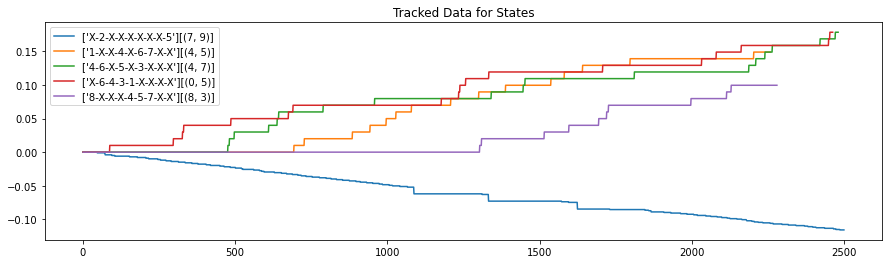

In [36]:
# Draw the plot using data captured through States_track for static states
plt.figure(figsize=(15, 4))
plt.plot(States_track['X-2-X-X-X-X-X-X-5'][(7, 9)], label = "['X-2-X-X-X-X-X-X-5'][(7, 9)]")
plt.plot(States_track['1-X-X-4-X-6-7-X-X'][(4, 5)], label = "['1-X-X-4-X-6-7-X-X'][(4, 5)]")
plt.plot(States_track['4-6-X-5-X-3-X-X-X'][(4, 7)], label = "['4-6-X-5-X-3-X-X-X'][(4, 7)]")
plt.plot(States_track['X-6-4-3-1-X-X-X-X'][(0, 5)], label = "['X-6-4-3-1-X-X-X-X'][(0, 5)]")
plt.plot(States_track['8-X-X-X-4-5-7-X-X'][(8, 3)], label = "['8-X-X-X-4-5-7-X-X'][(8, 3)]")
plt.title('Tracked Data for States')
plt.legend()
plt.show()

#### From States_track data we can observer agent is able to learn on every episode and  Q-values learnt by the agent have converged for few states mentioned in above plots

### Epsilon - decay check

In [37]:
max_epsilon = 1.0
min_epsilon = 0.001
time_steps = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

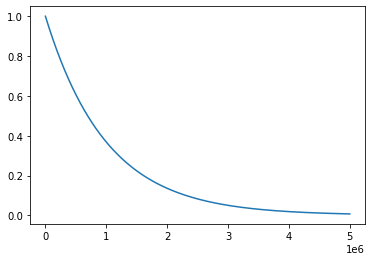

In [38]:
plt.plot(time_steps, epsilon)
plt.show()